# 01 - Blackbox Optimization Benchmarking Problem [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/01_bbob.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX on NVIDIA GPU with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install `evosax` from PyPi:

In [ ]:
%pip install -U "evosax[examples]"

## Import

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy
from evosax.problems import (
    BBOBProblem as Problem,
    MetaBBOBProblem as MetaProblem,
    bbob_fns,
)
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
seed = 0
key = jax.random.key(seed)

## Visualize BBOB functions

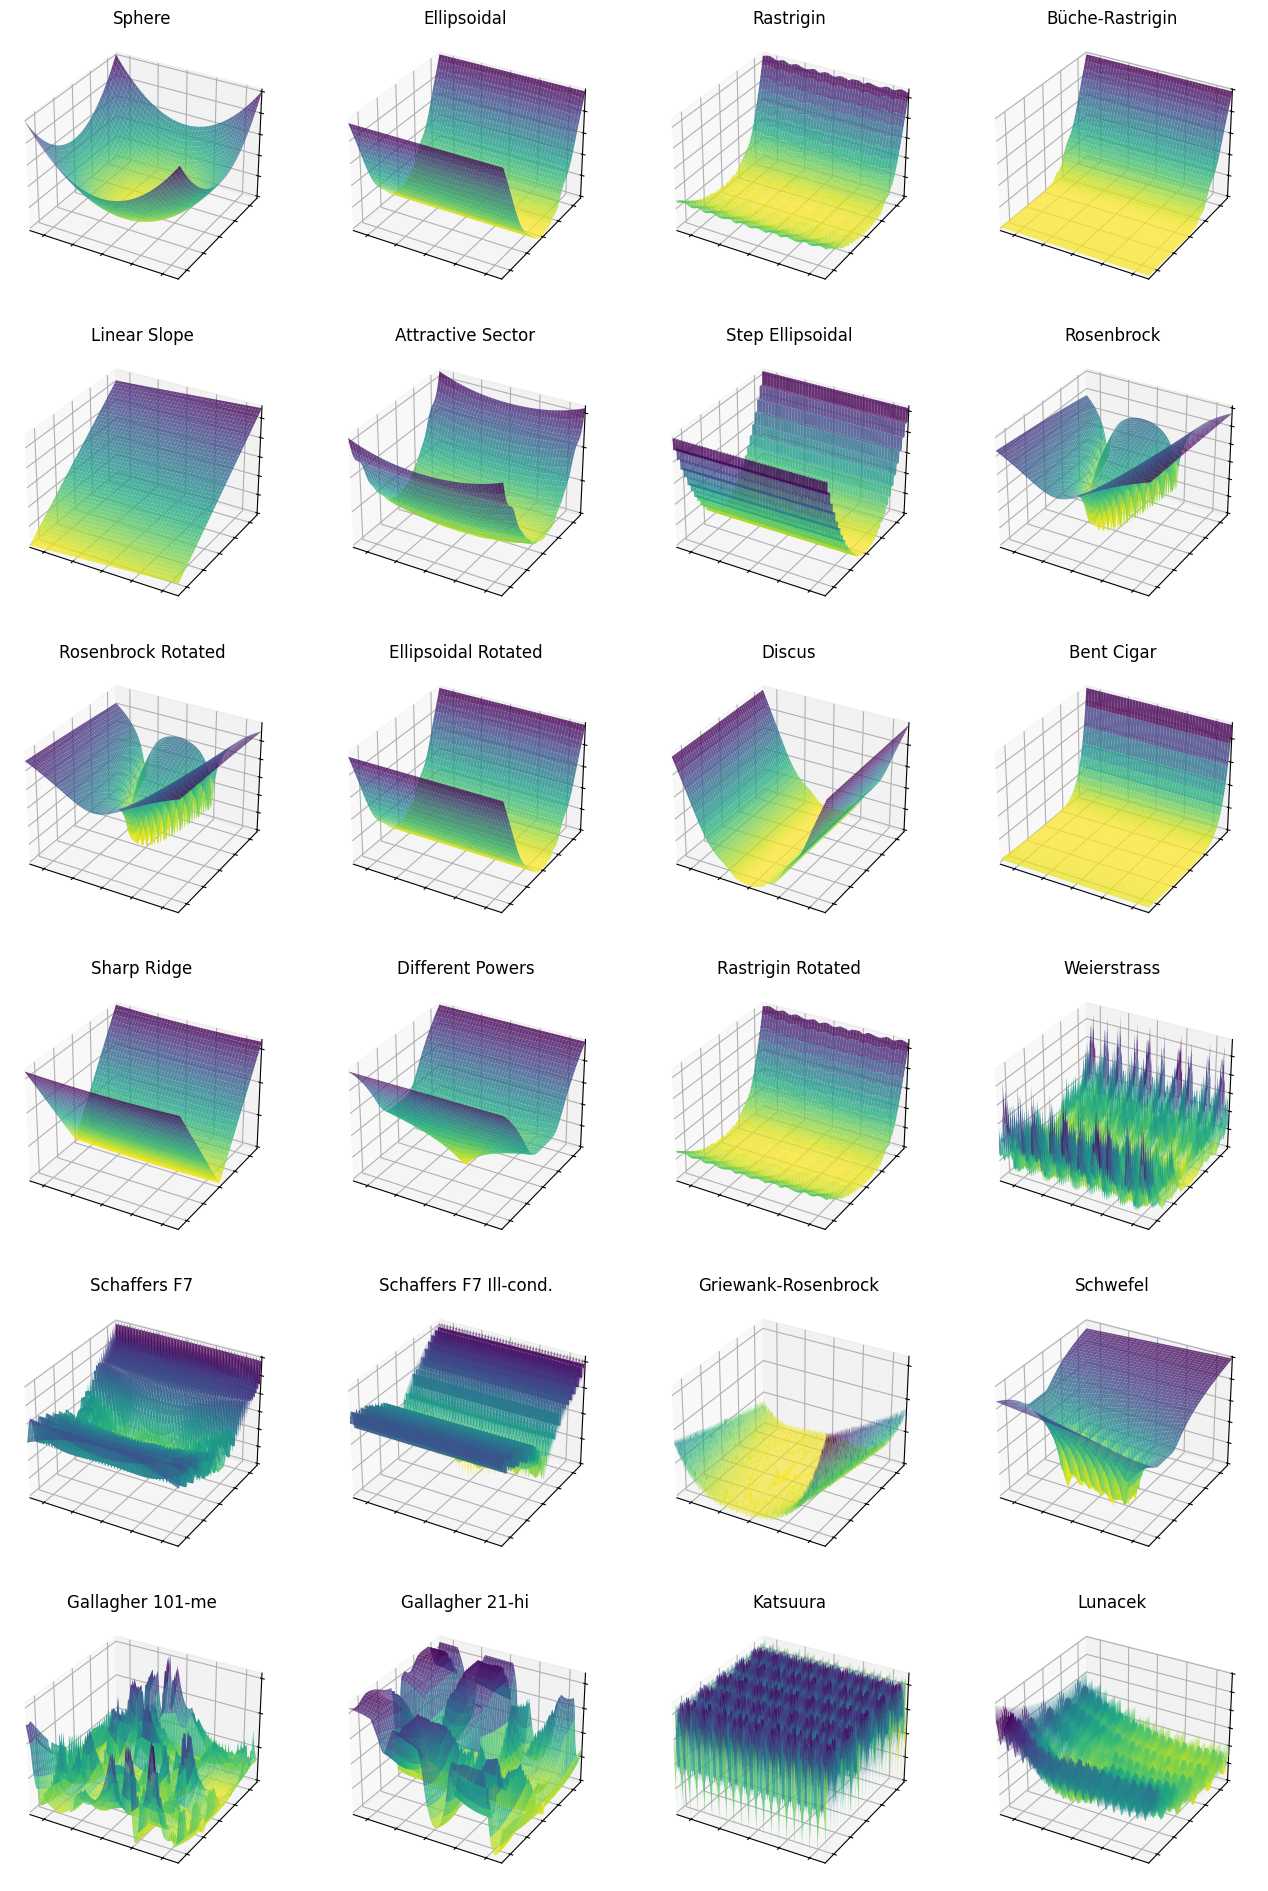

In [3]:
num_dims = 2

# Instantiates all BBOB problems
problems = {
    bbob_fn: Problem(
        fn_name=bbob_fn,
        num_dims=num_dims,
        x_opt=jnp.array([0.0, 0.0]),
        f_opt=0.0,
        sample_rotations=False,
    )
    for bbob_fn in bbob_fns
}

# List of functions to use logscale for
logscale_functions = [
    "rosenbrock",
    "rosenbrock_rotated",
    "different_powers",
    "schaffers_f7",
    "schaffers_f7_ill_cond",
    "schwefel",
    "katsuura",
]

# Create a figure with 6 rows and 4 columns
fig, axes = plt.subplots(6, 4, figsize=(16, 24), subplot_kw={"projection": "3d"})
axes = axes.flatten()

# Loop through all BBOB functions
for i, fn_name in enumerate(bbob_fns):
    # Get the problem for this function
    problem = problems[fn_name]

    # Plot the function on the corresponding axis
    key, subkey = jax.random.split(key)
    problem.visualize_3d(subkey, ax=axes[i], logscale=fn_name in logscale_functions)

    # Remove some elements to make the grid cleaner
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_zlabel("")

    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].set_zticklabels([])

plt.show()

## Visualize optimization

### Instantiate optimization problem

In [8]:
fn_name = "schaffers_f7"
num_dims = 2

problem = Problem(
    fn_name=fn_name,
    num_dims=num_dims,
    x_opt=2.5 * jnp.ones(num_dims),
    f_opt=0.0,
    # sample_rotations=False,
    seed=seed,
)

problem_state = problem.init(key)

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

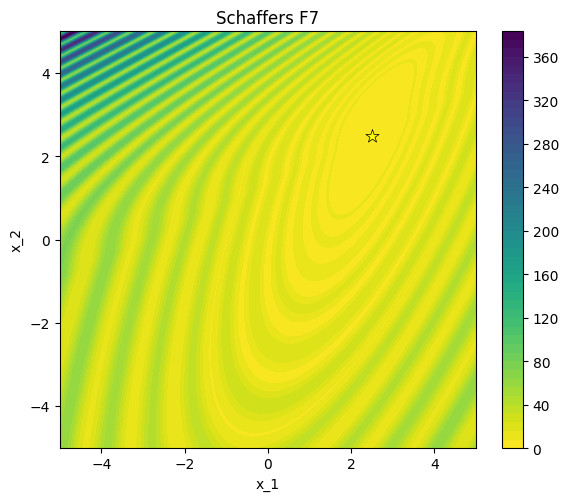

In [9]:
problem.visualize_2d(key, logscale=False)

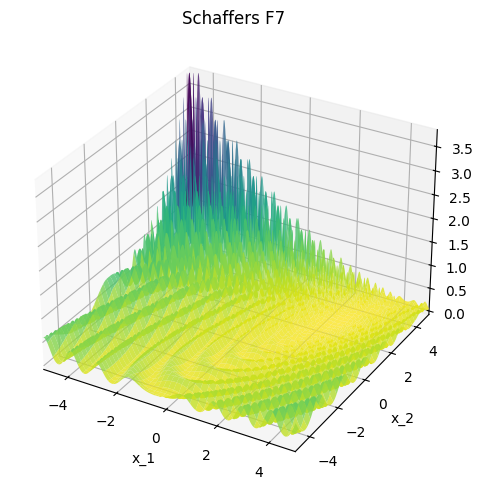

In [10]:
problem.visualize_3d(key, logscale=False)

### Instantiate CMA-ES

In [11]:
from evosax.algorithms import CMA_ES as ES

population_size = 128


def metrics_fn(key, population, fitness, state, params):
    """Compute metrics for evolution strategy."""
    idx = jnp.argmin(fitness)
    return {"best_fitness": fitness[idx], "mean": state.mean}


es = ES(
    population_size=population_size,
    solution=solution,
    metrics_fn=metrics_fn,
)

params = es.default_params

key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

### Run

In [12]:
def step(carry, key):
    state, params, problem_state = carry
    key_ask, key_eval, key_tell = jax.random.split(key, 3)

    population, state = es.ask(key_ask, state, params)

    population = jnp.clip(population, -5, 5)
    fitness, problem_state, _ = problem.eval(key_eval, population, problem_state)

    state, metrics = es.tell(key_tell, population, fitness, state, params)

    return (state, params, problem_state), metrics

In [13]:
num_generations = 64

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_generations)
_, metrics = jax.lax.scan(
    step,
    (state, params, problem_state),
    keys,
)

### Visualize

""

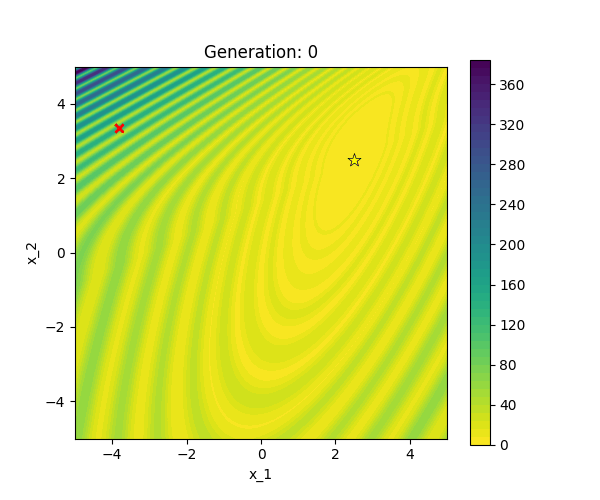

In [15]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Visualize the problem landscape
key, subkey = jax.random.split(key)
problem.visualize_2d(subkey, ax=ax)

# Extract mean trajectory from metrics
means = metrics["mean"]  # Shape: (num_generations, num_dims)

# Create a scatter plot for the current position
scatter = ax.scatter([], [], color="red", marker="x", linewidth=2)

# Add a title with generation counter
title = ax.set_title("Generation: 0")


def init():
    scatter.set_offsets(jnp.empty((0, 2)))
    return scatter, title


def update(frame):
    # Update the position of the mean
    scatter.set_offsets(means[frame].reshape(1, -1))

    # Update the title with current generation
    title.set_text(f"Generation: {frame}")

    return scatter, title


# Create the animation
anim = FuncAnimation(fig, update, frames=len(means), init_func=init, blit=True)
plt.close()

# Create a writer
path = "anim.gif"
anim.save(path, writer=PillowWriter())

# Display the GIF in the notebook
mediapy.show_video(mediapy.read_video(path), fps=20, codec="gif")

## MetaBBO

In [7]:
meta_problem = MetaProblem(
    fn_names=[
        "sphere",
        "ellipsoidal",
        "rastrigin",
        "bueche_rastrigin",
        "linear_slope",
        "attractive_sector",
        "step_ellipsoidal",
        "rosenbrock",
        "rosenbrock_rotated",
        "ellipsoidal_rotated",
        "discus",
        "bent_cigar",
        "sharp_ridge",
        "different_powers",
        "rastrigin_rotated",
        "weierstrass",
        "schaffers_f7",
        "schaffers_f7_ill_cond",
        "griewank_rosenbrock",
        "katsuura",
        "lunacek",
    ],
    min_num_dims=2,
    max_num_dims=16,
)

## ES comparison

In [8]:
import optax
from evosax.algorithms import algorithms

num_generations = 8_192
population_size = 1_024
num_tasks = 128

es_dict = {
    "SimpleES": {},
    "PGPE": {},
    "Open_ES": {"optimizer": optax.adam(1e-3)},
    "SNES": {},
    "Sep_CMA_ES": {},
    "CMA_ES": {},
}

# Dictionary to store results for each ES
results = {}

# Sample BBOB tasks
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_tasks)
problem_params = jax.vmap(meta_problem.sample_params)(keys)
problem_params = problem_params.replace(f_opt=jnp.zeros_like(problem_params.f_opt))

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_tasks)
problem_state = jax.vmap(meta_problem.init)(keys, problem_params)

# Sample dummy solution
key, subkey = jax.random.split(key)
solution = meta_problem.sample(subkey)

# Sample initial solutions
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_tasks)
solutions = jax.vmap(meta_problem.sample)(keys)

# Loop over the selected ES algorithms
for es_name in es_dict:
    print(f"Running {es_name}...")

    # Get the ES class from the algorithms dictionary
    ES = algorithms[es_name]

    # Initialize the ES
    es = ES(
        population_size=population_size,
        solution=solution,
        **es_dict[es_name],
    )
    params = es.default_params

    # Initialize ES state for each BBOB task
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, num_tasks)
    state = jax.vmap(es.init, in_axes=(0, 0, None))(keys, solutions, params)

    # Define the step function for the scan
    def step(carry, key):
        state, params, problem_state, problem_params = carry
        key_ask, key_eval, key_tell = jax.random.split(key, 3)

        # Ask - Eval - Tell
        population, state = es.ask(key_ask, state, params)
        population = jnp.clip(population, -5.0, 5.0)
        fitness, problem_state, _ = meta_problem.eval(
            key_eval, population, problem_state, problem_params
        )
        state, metrics = es.tell(key_tell, population, fitness, state, params)

        return (state, params, problem_state, problem_params), (state, metrics)

    @jax.jit
    def eval(key, params, problem_state, problem_params):
        # Init state
        key, subkey = jax.random.split(key)
        solution = jnp.clip(meta_problem.sample(subkey), -4.0, 4.0)

        key, subkey = jax.random.split(key)
        state = es.init(subkey, solution, params)

        # Scan
        keys = jax.random.split(subkey, num_generations)
        (state, params, problem_state, problem_params), (states, metrics) = (
            jax.lax.scan(
                step,
                (state, params, problem_state, problem_params),
                keys,
                length=num_generations,
            )
        )

        return metrics, states.mean[-1]

    # Run evaluation across all tasks
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, num_tasks)
    metrics_batch, final_means = jax.vmap(eval, in_axes=(0, None, 0, 0))(
        keys, params, problem_state, problem_params
    )

    # Average metrics across tasks
    metrics = jax.tree.map(lambda x: jnp.mean(x, axis=0), metrics_batch)

    # Store the results
    results[es_name] = metrics

Running SimpleES...
Running PGPE...
Running Open_ES...
Running SNES...
Running Sep_CMA_ES...
Running CMA_ES...


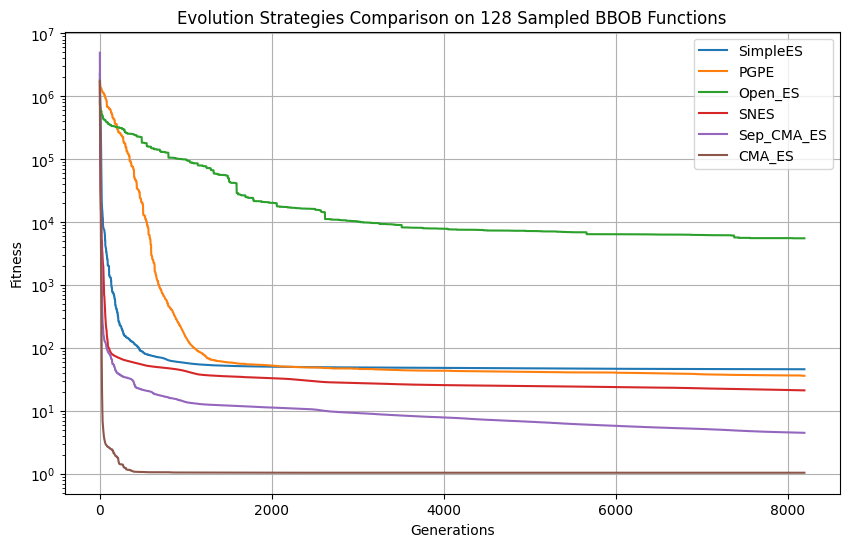

In [9]:
# Plot the fitness over generations for each ES
plt.figure(figsize=(10, 6))
for es_name, metrics in results.items():
    plt.plot(metrics["best_fitness"], label=es_name)

plt.title(f"Evolution Strategies Comparison on {num_tasks} Sampled BBOB Functions")
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.yscale("log")

plt.legend()
plt.grid(True)

plt.show()